# Visión por Computadora II - TP Integrador

**Dataset**: [fruits-360](https://www.kaggle.com/datasets/moltean/fruits)

In [20]:
# importamos librerias
import os
import gdown
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from collections import Counter
import random
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

---
## 1) Dataset

In [2]:
dataset_zip = 'fruits-360_100x100.zip'
%store dataset_zip

# Descargar el dataset
if os.access(dataset_zip, os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL'
    gdown.download(url, dataset_zip)
else:
    print("El dataset ya se encuentra descargado")

Stored 'dataset_zip' (str)


Downloading...
From (original): https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL
From (redirected): https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL&confirm=t&uuid=4bc26c6b-0bb1-4425-9f4e-8d5eaefe6a05
To: /content/fruits-360_100x100.zip
100%|██████████| 423M/423M [00:03<00:00, 126MB/s]


In [3]:
!unzip -q "$dataset_zip"

---
### 1.1) Análisis exploratorio del dataset

- El dataset Fruit-360 es una colección diseñada específicamente para tareas de clasificación de frutas. Contiene un total de 81 clases, cada una representando una categoría diferente de frutas. El conjunto de datos está organizado en:
   - Conjunto de entrenamiento: 70491 imágenes.
   - Conjunto de prueba: 23619 imágenes.
   - En total, el dataset incluye 94110 imágenes.

- Para capturar las imágenes, se utilizó un motor de baja velocidad (3 rpm) que giraba las frutas, grabando un corto video de 20 segundos. Debido a las variaciones en las condiciones de iluminación durante las filmaciones, los fondos originales no eran uniformes. Por esta razón, se estandarizó el fondo de todas las imágenes, convirtiéndolo en color blanco.

- Cada imagen tiene un tamaño de 100x100 píxeles con fondo blanco. Esta resolución y uniformidad son esenciales para la clasificación de imágenes, ya que muchas frutas comparten colores y formas similares, aunque difieren en tamaño. A su vez, algunas frutas tienen el mismo tamaño, color y forma, pero pertenecen a diferentes variedades dentro de una misma categoría (por ejemplo, variantes de manzanas, mangos o tomates). Para abordar esta diversidad, las distintas variantes de una misma fruta se clasificaron como clases separadas.

- A diferencia de otros datasets generales de clasificación de imágenes, el Fruit-360 se enfoca exclusivamente en frutas. Esto implica un desafío adicional debido a las grandes similitudes intra-clase, ya que frutas de la misma categoría comparten características visuales muy similares. Por lo tanto, este dataset representa un excelente punto de partida para explorar las capacidades de modelos de clasificación de imágenes y analizar su rendimiento frente a clases con características sutilmente diferenciadas.

In [44]:
# imprimir cantidad de imagenes de train y test
train_folder = 'Training/'
test_folder = 'Test/'

train_images = sum([len(files) for r, d, files in os.walk(train_folder)])
test_images = sum([len(files) for r, d, files in os.walk(test_folder)])
total_images = train_images + test_images

print(f"Cantidad de imagenes en train: {train_images}")
print(f"Cantidad de imagenes en test: {test_images}")
print(f"Total de imagenes: {total_images}")

Cantidad de imagenes en train: 70491
Cantidad de imagenes en test: 23619
Total de imagenes: 94110


In [ ]:
# todo: mergear las clases que tienen varias tomas de la misma fruta/verdura

# todo: crear un dataset chico para entrenar rapido, pocas imagenes por clase

In [13]:
# exploracion de las clases del dataset
classes = os.listdir(train_folder)
print(f"Se encontraron {len(classes)} clases de frutas")
print(f"Primeras 10 clases:")
print(classes[:10])

# todo: mergear las clases que tienen varias tomas de la misma fruta/verdura

Se encontraron 141 clases de frutas
Primeras 10 clases:
['Tomato 1', 'Lemon 1', 'Physalis 1', 'Mulberry 1', 'Chestnut 1', 'Banana Lady Finger 1', 'Plum 1', 'Melon Piel de Sapo 1', 'Pear 2', 'Cherry Wax Red 1']


In [36]:
# cantidad de imágenes por clase
class_counts = {cls: len(os.listdir(os.path.join(train_folder, cls))) for cls in classes}
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
print(f"Cantidad de imágenes por clase:")
print(sorted_class_counts)

Cantidad de imágenes por clase:
{'Grape Blue 1': 984, 'Plum 3': 900, 'Tomato 1': 738, 'Melon Piel de Sapo 1': 738, 'Tomato 3': 738, 'Peach 2': 738, 'Cherry Rainier 1': 738, 'Strawberry Wedge 1': 738, 'Cherry 2': 738, 'Walnut 1': 735, 'Pear Stone 1': 711, 'Apple hit 1': 702, 'Cauliflower 1': 702, 'Fig 1': 702, 'Pear Forelle 1': 702, 'Pepper Orange 1': 702, 'Pear 2': 696, 'Tomato Heart 1': 684, 'Apple Red Yellow 2': 672, 'Tomato 2': 672, 'Pear Red 1': 666, 'Pepper Red 1': 666, 'Pepper Yellow 1': 666, 'Nut Forest 1': 654, 'Nut Pecan 1': 534, 'Pineapple Mini 1': 493, 'Lemon 1': 492, 'Physalis 1': 492, 'Mulberry 1': 492, 'Cherry Wax Red 1': 492, 'Apple Red Yellow 1': 492, 'Cherry Wax Yellow 1': 492, 'Physalis with Husk 1': 492, 'Redcurrant 1': 492, 'Apple Red 1': 492, 'Apple Red 2': 492, 'Cherry 1': 492, 'Pomegranate 1': 492, 'Cantaloupe 1': 492, 'Papaya 1': 492, 'Grape Pink 1': 492, 'Cantaloupe 2': 492, 'Tomato Cherry Red 1': 492, 'Apple Golden 2': 492, 'Grape White 3': 492, 'Peach Flat 1'

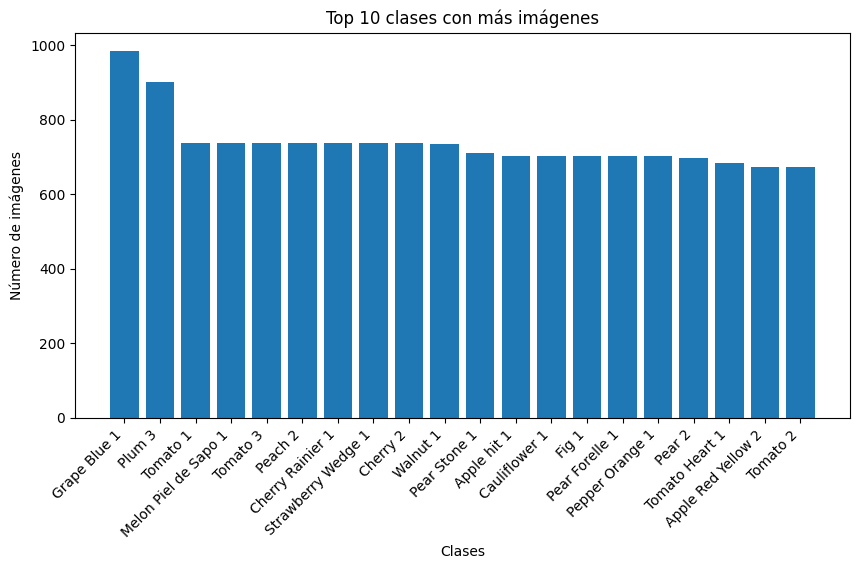

In [33]:
# visualizamos las clases con más imágenes
top_classes = dict(Counter(class_counts).most_common(20))
plt.figure(figsize=(10, 5))
plt.bar(top_classes.keys(), top_classes.values())
plt.title("Top 20 clases con más imágenes")
plt.xlabel("Clases")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45, ha="right")
plt.show()

In [39]:
# tamaño de las imágenes
image_shapes = []
for cls in classes:
    folder = os.path.join(train_folder, cls)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = Image.open(img_path)
        image_shapes.append(img.size)

widths, heights = zip(*image_shapes)
print(f"Tamaño promedio de las imágenes: {np.mean(widths):.2f}x{np.mean(heights):.2f}")
print(f"Tamaño mínimo: {min(widths)}x{min(heights)}, máximo: {max(widths)}x{max(heights)}")

Tamaño promedio de las imágenes: 100.00x100.00
Tamaño mínimo: 100x100, máximo: 100x100


---
### 1.2) Visualización de los datos

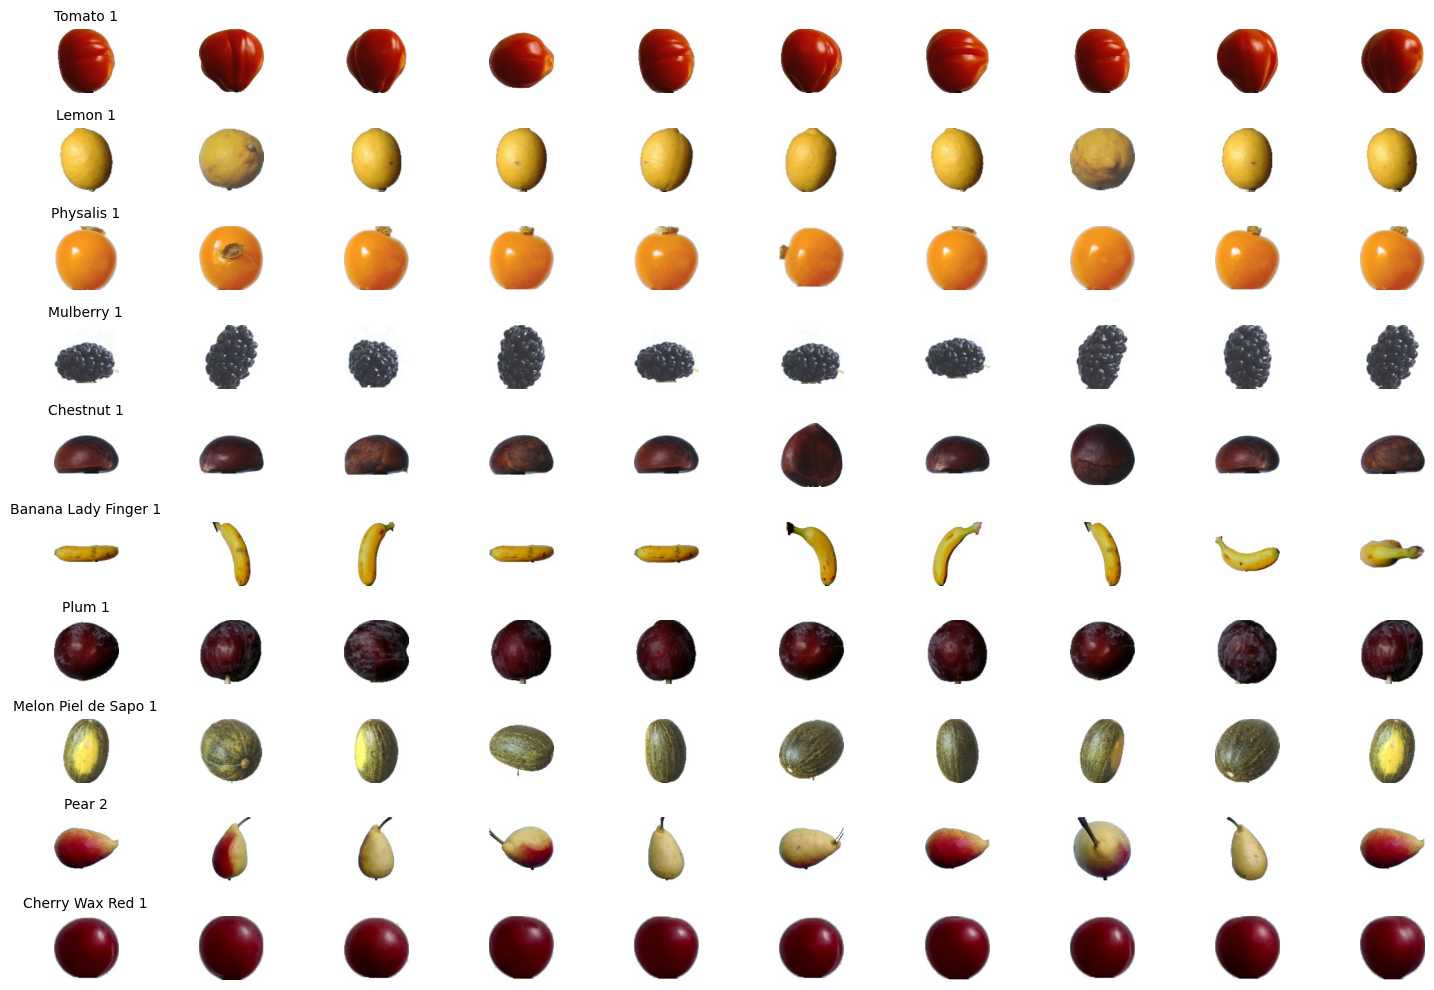

In [45]:
# visualiza imágenes de ejemplo
def mostrar_ejemplos(data_dir, classes, num_imagenes=5):
    fig, axes = plt.subplots(len(classes), num_imagenes, figsize=(15, 10))
    for i, cls in enumerate(classes):
        folder = os.path.join(data_dir, cls)
        images = os.listdir(folder)[:num_imagenes]
        for j, img_file in enumerate(images):
            img_path = os.path.join(folder, img_file)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls, fontsize=10)
    plt.tight_layout()
    plt.show()

mostrar_ejemplos(train_folder, classes[:10], num_imagenes=10)

---
### 1.2) Data Augmentation



In [ ]:
# wip

---
## 2) Modelos

### 2.1) Modelo 1: ?

In [ ]:
# wip

---
### 2.1) Modelo 2: ?

In [ ]:
# wip